Perfecto, hermano. Lo que haremos es integrar tu calendario económico al modelo de AI LSTM, sin cambiar la estructura principal del modelo. Solo vamos a añadir una nueva feature (característica) que represente el impacto de noticias económicas para que el modelo LSTM lo tome en cuenta como una variable adicional al precio.


🔍 ¿Qué estamos haciendo exactamente?
Obtener el calendario económico y convertirlo en un vector de impacto diario.

Unir ese impacto con el DataFrame de precios históricos.

Normalizar ambos: precio e impacto de noticias.

Agregar el impacto como segunda feature al LSTM (input shape (n, 10, 2)).

Entrenar y predecir como siempre, pero usando también las noticias.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ib_insync import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import requests
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

In [29]:
util.startLoop()

In [30]:
#Conexion con TWS para obtener datos
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

In [31]:
# --- DATOS DE LA ACCIÓN COIN ---
contract = Stock('COIN', 'SMART', 'USD')
bars = ib.reqHistoricalData(
    contract,
    endDateTime='',
    durationStr='60 D',
    barSizeSetting='1 day',
    whatToShow='TRADES',
    useRTH=True,
    formatDate=1
)

In [32]:
df = pd.DataFrame(bars)
df['Fecha'] = pd.to_datetime(df['date'])
df['Precio'] = df['close']
df = df[['Fecha', 'Precio']]  # Solo columnas necesarias


In [33]:
# --- CALENDARIO ECONÓMICO DESDE TRADINGVIEW ---
today = datetime.now(ZoneInfo("America/Lima")).date()
desde = today.isoformat() + 'T00:00:00.000Z'
hasta = (today + timedelta(days=3)).isoformat() + 'T23:59:59.999Z'

In [34]:
#detalles de la pagina para obetener la noticias del calendario economico
headers = {'Origin': 'https://www.tradingview.com'}
params = {'from': desde, 'to': hasta}
url = 'https://economic-calendar.tradingview.com/events'
response = requests.get(url, headers=headers, params=params)


In [38]:
if response.status_code == 200:
    data = response.json()
    eventos = data.get('result', [])
    df_news = pd.DataFrame(eventos)

    if 'date' in df_news.columns:
        df_news['datetime_utc'] = pd.to_datetime(df_news['date'], utc=True)
        df_news['datetime_peru'] = df_news['datetime_utc'].dt.tz_convert('America/Lima')
        df_news['Fecha'] = df_news['datetime_peru'].dt.date
        df_news['impacto'] = df_news['importance'].map({'low': 0.2, 'medium': 0.5, 'high': 1.0})
        impacto_diario = df_news.groupby('Fecha')['impacto'].sum().reset_index()
        impacto_diario.columns = ['Fecha', 'Impacto_Noticias']
        impacto_diario['Fecha'] = pd.to_datetime(impacto_diario['Fecha'])
else:
    print(f"Error al obtener el calendario económico: {response.status_code}")
    impacto_diario = pd.DataFrame(columns=['Fecha', 'Impacto_Noticias'])

In [39]:
# --- FUSIONAR IMPACTO CON PRECIOS ---
df = df.merge(impacto_diario[['Fecha', 'Impacto_Noticias']], on='Fecha', how='left')
df['Impacto_Noticias'] = df['Impacto_Noticias'].fillna(0.0)  # ✅ Corregido: sin warning

In [40]:
# --- NORMALIZACIÓN ---
scaler_precio = MinMaxScaler()
scaler_impacto = MinMaxScaler()
df['Precio_Normalizado'] = scaler_precio.fit_transform(df[['Precio']])
df['Impacto_Normalizado'] = scaler_impacto.fit_transform(df[['Impacto_Noticias']])

In [41]:
# --- CREAR SECUENCIAS PARA LSTM ---
def create_sequences_multifeature(data1, data2, seq_length=10):
    sequences = []
    labels = []
    for i in range(len(data1) - seq_length):
        seq = np.column_stack((data1[i:i+seq_length], data2[i:i+seq_length]))
        sequences.append(seq)
        labels.append(data1[i + seq_length])  # Target: precio normalizado futuro
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences_multifeature(
    df['Precio_Normalizado'].values,
    df['Impacto_Normalizado'].values,
    seq_length
)

In [42]:
# --- MODELO LSTM ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 2)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
# --- ENTRENAMIENTO ---
model.fit(X, y, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1770
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0553 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0131 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━

In [44]:
# --- PREDICCIÓN ---
last_price_seq = df['Precio_Normalizado'].values[-seq_length:]
last_impact_seq = df['Impacto_Normalizado'].values[-seq_length:]
last_sequence = np.column_stack((last_price_seq, last_impact_seq))
last_sequence = last_sequence.reshape(1, seq_length, 2)

prediction = model.predict(last_sequence)
predicted_price = scaler_precio.inverse_transform(prediction.reshape(-1, 1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


In [45]:
# --- FIBONACCI ---
max_price = df['Precio'].max()
min_price = df['Precio'].min()
diff = max_price - min_price
fibonacci_levels = [0.236, 0.382, 0.5, 0.618, 0.786]
fib_lines = [max_price - diff * level for level in fibonacci_levels]


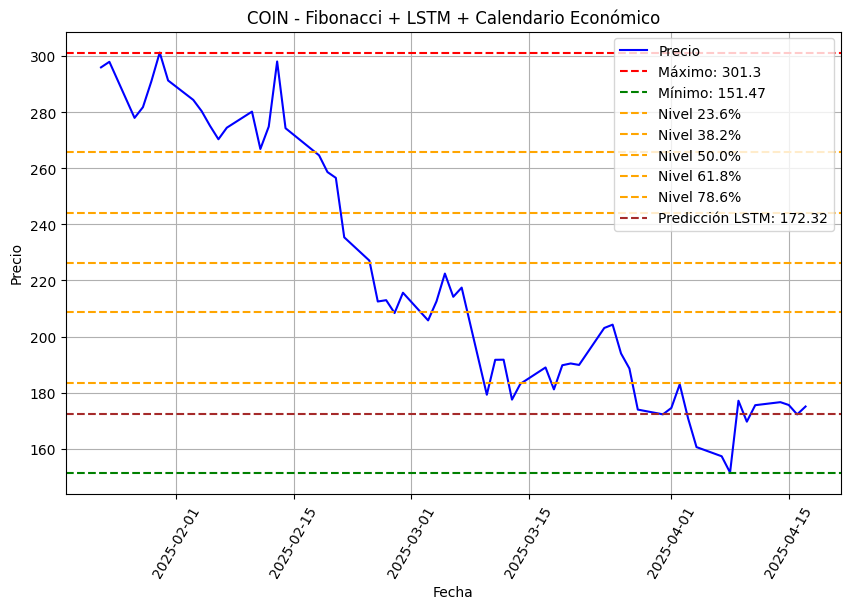

In [ ]:
# --- GRAFICAR --- Muestra de nuestra prediccion con fibonacci + LTSM
plt.figure(figsize=(10, 6))
plt.plot(df['Fecha'], df['Precio'], label='Precio', color='blue')
plt.axhline(y=max_price, linestyle='--', color='red', label=f'Máximo: {max_price}')
plt.axhline(y=min_price, linestyle='--', color='green', label=f'Mínimo: {min_price}')
plt.xticks(rotation=60)

# Fibonacci
for level, line in zip(fibonacci_levels, fib_lines):
    plt.axhline(y=line, linestyle='--', color='orange', label=f'Nivel {level*100:.1f}%')

# Predicción
plt.axhline(y=predicted_price, linestyle='--', color='brown', label=f'Predicción LSTM: {predicted_price:.2f}')
plt.legend()
plt.title('COIN - Fibonacci + LSTM + Calendario Económico')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid() #hace las rayas verticales y horizontales
plt.show()

In [49]:
ib.disconnect()